# CNN-Baseline for Google Landmark Recognition 2020

In [22]:
import os
import re
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import load_model
from keras.applications import ResNet50V2, VGG16, Xception
from glob import glob

In [75]:
# base directory
BASE_DIR = '..'

# data directory
DATA_DIR = os.path.join(BASE_DIR, 'data')

# raw, interim & processed data directory
RAW_DIR = os.path.join(DATA_DIR, 'raw')
INTERIM_DIR = os.path.join(DATA_DIR, 'interim')
PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')


# raw data
TRAIN = os.path.join(RAW_DIR, 'train')
TEST = os.path.join(RAW_DIR, 'test')
DF_TRAIN = os.path.join(TRAIN, 'train.csv')
LANDMARK100 = os.path.join(RAW_DIR, 'landmark100.csv')
SAMPLE_SUBMISSION = os.path.join(RAW_DIR, 'sample_submission.csv')

# interim data
TRAIN_BY_CLASS = os.path.join(INTERIM_DIR, 'train')
VALIDATION_BY_CLASS = os.path.join(INTERIM_DIR, 'validation')
TEST_BY_CLASS = os.path.join(INTERIM_DIR, 'test')

## Data Preparation

In [61]:
try:
    os.mkdir(TRAIN_BY_CLASS)
    os.mkdir(VALIDATION_BY_CLASS)
    
except OSError as e:
    print(e)

[WinError 183] Cannot create a file when that file already exists: '..\\data\\interim\\test'


In [11]:
df_map = pd.read_csv(DF_TRAIN)
len(df_map)

1580470

In [6]:
im_train = glob(os.path.join(TRAIN, '*/*/*/*.jpg'))
im_test = glob(os.path.join(TEST, '*/*/*/*.jpg'))

In [101]:
print('sample path for train images: ', im_train[:1])
print('sample path for test images: ', im_test[:1])

sample path for train images:  ['..\\data\\raw\\train\\3\\0\\0\\300018a3f2c53762.jpg']
sample path for test images:  ['..\\data\\raw\\test\\0\\0\\0\\00084cdf8f600d00.jpg']


In [12]:
def clean_f_names(f_names):
    
    res = []
    
    for name in f_names:
        try:
            basename = os.path.basename(name)
            new_name = os.path.splitext(basename)[0]
            res.append((name, new_name))
            
        except AttributeError:
            print('Not found')
    
    return res

In [14]:
im_train2 = clean_f_names(im_train)
im_test2 = clean_f_names(im_test)

In [16]:
print('New names:', im_train2[0])
print('New names:', im_test2[0])

New names: ('..\\data\\raw\\train\\3\\0\\0\\300018a3f2c53762.jpg', '300018a3f2c53762')
New names: ('..\\data\\raw\\test\\0\\0\\0\\00084cdf8f600d00.jpg', '00084cdf8f600d00')


In [17]:
df_train_fname = pd.DataFrame(im_train2, columns =['path', 'f_name']) 
df_test_fname = pd.DataFrame(im_test2, columns =['path', 'f_name']) 

In [21]:
df_train_fname.head()

,path,f_name
0,..\data\raw\train\3\0\0\300018a3f2c53762.jpg,300018a3f2c53762
1,..\data\raw\train\3\0\0\30001f5fcffe167e.jpg,30001f5fcffe167e
2,..\data\raw\train\3\0\0\3000256de7db05cb.jpg,3000256de7db05cb
3,..\data\raw\train\3\0\0\30002609e59e9dac.jpg,30002609e59e9dac
4,..\data\raw\train\3\0\0\30003356c82cbb38.jpg,30003356c82cbb38


In [19]:
df_test_fname.head()

,path,f_name
0,..\data\raw\test\0\0\0\00084cdf8f600d00.jpg,00084cdf8f600d00
1,..\data\raw\test\0\0\0\000b15b043eb8cf0.jpg,000b15b043eb8cf0
2,..\data\raw\test\0\0\1\0011a52f9b948fd2.jpg,0011a52f9b948fd2
3,..\data\raw\test\0\0\1\00141b8a5a729084.jpg,00141b8a5a729084
4,..\data\raw\test\0\0\1\0018aa4b92532b77.jpg,0018aa4b92532b77


In [22]:
df_map.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [23]:
df_train = df_train_fname.merge(df_map, left_on='f_name', right_on='id')

In [24]:
df_train.head()

,path,f_name,id,landmark_id
0,..\data\raw\train\3\0\0\300018a3f2c53762.jpg,300018a3f2c53762,300018a3f2c53762,139867
1,..\data\raw\train\3\0\0\30001f5fcffe167e.jpg,30001f5fcffe167e,30001f5fcffe167e,110224
2,..\data\raw\train\3\0\0\3000256de7db05cb.jpg,3000256de7db05cb,3000256de7db05cb,139172
3,..\data\raw\train\3\0\0\30002609e59e9dac.jpg,30002609e59e9dac,30002609e59e9dac,126437
4,..\data\raw\train\3\0\0\30003356c82cbb38.jpg,30003356c82cbb38,30003356c82cbb38,53692


### Only use landmark_id with > N samples

In [56]:
N_SAMPLE = 100

vc = df_train['landmark_id'].value_counts() > N_SAMPLE
vc = vc[vc]

df_train2 = df_train.loc[df_train['landmark_id'].isin(vc.index)]
df_train2.head()

,path,f_name,id,landmark_id
5,..\data\raw\train\3\0\0\3000760928c3faf4.jpg,3000760928c3faf4,3000760928c3faf4,5004
9,..\data\raw\train\3\0\0\30009ae1c4c90b22.jpg,30009ae1c4c90b22,30009ae1c4c90b22,138982
58,..\data\raw\train\3\0\0\3002665a49233868.jpg,3002665a49233868,3002665a49233868,177870
61,..\data\raw\train\3\0\0\30027424ea6369ea.jpg,30027424ea6369ea,30027424ea6369ea,73300
96,..\data\raw\train\3\0\0\3004060a49765c4a.jpg,3004060a49765c4a,3004060a49765c4a,73300


In [63]:
len(df_train2)

42295


### Seperate training images into their respective landmark_id folders

In [ ]:
for i, row in df_train2.iterrows():
    
    class_dir = os.path.join(TRAIN_BY_CLASS, row['landmark_id'])
    
    if not os.path.exists(class_dir):
        os.mkdir(class_dir)
    
    shutil.copy(row['path'], class_dir)

### Select M samples for validation (M < N)

In [4]:
classes_id = os.listdir(TRAIN_BY_CLASS)
classes_id

['5004',
 '138982',
 '177870',
 '73300',
 '115821',
 '83144',
 '180901',
 '126637',
 '53185',
 '75005',
 '100631',
 '132969',
 '102904',
 '36748',
 '76303',
 '20409',
 '70088',
 '35628',
 '13471',
 '91659',
 '120734',
 '100230',
 '190216',
 '90021',
 '105496',
 '84939',
 '142147',
 '180759',
 '55623',
 '165900',
 '65658',
 '164191',
 '39865',
 '179626',
 '109169',
 '161902',
 '45428',
 '163179',
 '31898',
 '44939',
 '144201',
 '47378',
 '122418',
 '173767',
 '139706',
 '152708',
 '168098',
 '108327',
 '31837',
 '136302',
 '149980',
 '151942',
 '69835',
 '139894',
 '120885',
 '42123',
 '51272',
 '86869',
 '27',
 '195412',
 '174181',
 '193505',
 '91274',
 '194914',
 '184907',
 '1924',
 '192931',
 '116124',
 '176528',
 '163227',
 '14915',
 '21635',
 '46705',
 '137203',
 '27364',
 '65068',
 '120144',
 '90966',
 '124455',
 '171683',
 '103899',
 '55219',
 '202814',
 '25457',
 '195562',
 '30048',
 '160944',
 '174834',
 '16658',
 '56827',
 '177409',
 '65818',
 '19605',
 '91059',
 '192235',
 '5

In [75]:
for class_id in classes_id:
    validation_class_dir = os.path.join(VALIDATION_BY_CLASS, class_id)
    
    if not os.path.exists(validation_class_dir):
        os.mkdir(validation_class_dir)    

In [80]:
M_SAMPLE = 50
for class_id in classes_id:
    train_class_dir = os.path.join(TRAIN_BY_CLASS, class_id)
    validation_class_dir = os.path.join(VALIDATION_BY_CLASS, class_id)

    files_to_move = glob(os.path.join(train_class_dir, '*'))[:M_SAMPLE]

    for f in files_to_move:
        shutil.move(f, validation_class_dir)

## Utility functions

In [5]:
# Plot training & validation accuracy, loss
def plot_acc_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

## Data Overview

In [6]:
im_train_classes_dir = glob(os.path.join(TRAIN_BY_CLASS, '*'))
im_validation_classes_dir = glob(os.path.join(VALIDATION_BY_CLASS, '*'))

total_training_images = sum(len(os.listdir(d)) for d in im_train_classes_dir)
total_validation_images = sum(len(os.listdir(d)) for d in im_validation_classes_dir)

print('total training classes: ', len(im_train_classes_dir))
print('total validation classes: ', len(im_train_classes_dir))
print('total training images: ', total_training_images)
print('total validation images: ', total_validation_images)

total training classes:  252
total validation classes:  252
total training images:  29695
total validation images:  12600


## Instantiate convolutional base

In [7]:
# ResNet50V2
conv_base = ResNet50V2(weights='imagenet', 
                  include_top=False,
                  input_shape=(150, 150, 3))

# VGG16
conv_base2 = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(150, 150, 3))

In [9]:
conv_base.summary()

n[0][0]          
__________________________________________________________________________________________________
conv4_block1_0_conv (Conv2D)    (None, 10, 10, 1024) 525312      conv4_block1_preact_relu[0][0]   
__________________________________________________________________________________________________
conv4_block1_3_conv (Conv2D)    (None, 10, 10, 1024) 263168      conv4_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_out (Add)          (None, 10, 10, 1024) 0           conv4_block1_0_conv[0][0]        
                                                                 conv4_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_preact_bn (BatchNo (None, 10, 10, 1024) 4096        conv4_block1_out[0][0]           
___________________________________________________________________________________________

## Data Generators

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_BY_CLASS,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    VALIDATION_BY_CLASS,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    TEST,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

Found 29695 images belonging to 252 classes.
Found 12600 images belonging to 252 classes.
Found 10345 images belonging to 16 classes.


## Model1
Fast feature extraction w/o data augmentation.

Run **ResNet50V2** over our dataset, record its output, then use output to train our classifier.

In [9]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 5, 5, 2048), dtype=np.float16)
    labels = np.zeros(shape=(sample_count, 252), dtype=np.uint8)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) # transform the input to feature
        
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features, labels

In [ ]:
train_features, train_labels = extract_features(TRAIN_BY_CLASS, total_training_images)
validation_features, validation_labels = extract_features(VALIDATION_BY_CLASS, total_validation_images)
# test_features, test_labels = extract_features(test_dir, 1000)

Features are currently of shape (samples, 4, 4, 512). We'll feed them to a classifier.

First, we flatten them to (samples, 8192)

In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Then, we define our classifier and train it on the data and labels we recorded

In [ ]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

In [ ]:
model.save('model1.h5')

In [ ]:
plot_acc_loss(history)

## Model 2
Feature extraction w/ data augmentation.

Extend our classifier on top of the **ResNet50V2**, then run the whole thing

In [25]:
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(252, activation='softmax'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_9 (Dense)              (None, 252)               64764     
Total params: 36,737,020
Trainable params: 13,172,220
Non-trainable params: 23,564,800
_________________________________________________________________


In [10]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model2.trainable_weights))

# Freeze the convolutional base to prevent their weights from being updated during training
# We only want to train the newly added layers
conv_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model2.trainable_weights))

This is the number of trainable weights before freezing the conv base: 176
This is the number of trainable weights after freezing the conv base: 4


In [26]:
model2.compile(loss='categorical_crossentropy',
               optimizer=optimizers.Adam(lr=2e-5),
               metrics=['acc'])

In [27]:
history2 = model2.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/10
100/100 [==============================] - 52s 518ms/step - loss: 5.5214 - acc: 0.0822 - val_loss: 5.7011 - val_acc: 0.0219
Epoch 2/10
100/100 [==============================] - 52s 522ms/step - loss: 4.9669 - acc: 0.1347 - val_loss: 5.5442 - val_acc: 0.0281
Epoch 3/10
100/100 [==============================] - 52s 515ms/step - loss: 4.7348 - acc: 0.1653 - val_loss: 5.3871 - val_acc: 0.0562
Epoch 4/10
100/100 [==============================] - 51s 505ms/step - loss: 4.5914 - acc: 0.1809 - val_loss: 5.3193 - val_acc: 0.0656
Epoch 5/10
100/100 [==============================] - 50s 499ms/step - loss: 4.4836 - acc: 0.1913 - val_loss: 5.1685 - val_acc: 0.0925
Epoch 6/10
100/100 [==============================] - 48s 476ms/step - loss: 4.3138 - acc: 0.2206 - val_loss: 4.9988 - val_acc: 0.1050
Epoch 7/10
100/100 [==============================] - 46s 461ms/step - loss: 4.1836 - acc: 0.2309 - val_loss: 4.9134 - val_acc: 0.1131
Epoch 8/10
100/100 [==============================] - 5

In [33]:
model2.save('model2.h5')

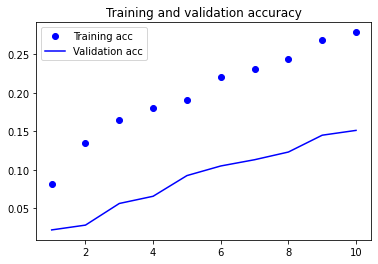

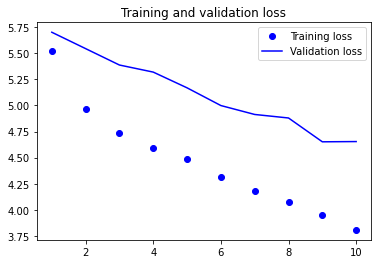

In [36]:
plot_acc_loss(history2)

## Model 3
Feature extraction w/ data augmentation.

Extend our classifier on top of the **VGG16**, then run the whole thing

In [37]:
model3 = models.Sequential()
model3.add(conv_base2)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(252, activation='softmax'))

model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_13 (Dense)             (None, 252)               64764     
Total params: 16,876,860
Trainable params: 16,876,860
Non-trainable params: 0
_________________________________________________________________


In [38]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model3.trainable_weights))

# Freeze the convolutional base to prevent their weights from being updated during training
# We only want to train the newly added layers
conv_base2.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model3.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [39]:
model3.compile(loss='categorical_crossentropy',
               optimizer=optimizers.Adam(lr=2e-5),
               metrics=['acc'])

In [40]:
history3 = model3.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/10
100/100 [==============================] - 51s 514ms/step - loss: 5.4817 - acc: 0.0484 - val_loss: 5.6170 - val_acc: 0.0050
Epoch 2/10
100/100 [==============================] - 51s 510ms/step - loss: 5.2654 - acc: 0.0709 - val_loss: 5.6185 - val_acc: 0.0044
Epoch 3/10
100/100 [==============================] - 51s 507ms/step - loss: 5.1157 - acc: 0.0775 - val_loss: 5.6087 - val_acc: 0.0044
Epoch 4/10
100/100 [==============================] - 51s 510ms/step - loss: 4.9822 - acc: 0.0950 - val_loss: 5.5955 - val_acc: 0.0081
Epoch 5/10
100/100 [==============================] - 47s 474ms/step - loss: 4.9469 - acc: 0.1041 - val_loss: 5.5571 - val_acc: 0.0150
Epoch 6/10
100/100 [==============================] - 51s 509ms/step - loss: 4.8671 - acc: 0.1203 - val_loss: 5.5668 - val_acc: 0.0125
Epoch 7/10
100/100 [==============================] - 48s 482ms/step - loss: 4.8122 - acc: 0.1275 - val_loss: 5.5248 - val_acc: 0.0156
Epoch 8/10
100/100 [==============================] - 4

In [54]:
model3.save('model3.h5')

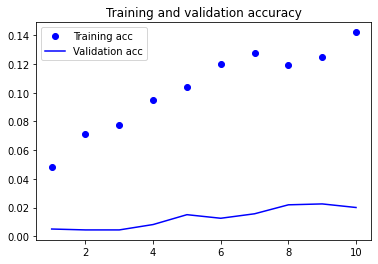

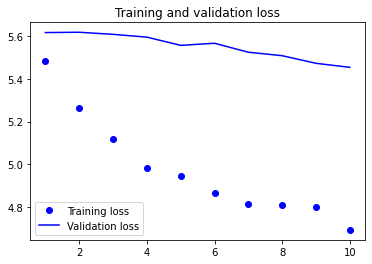

In [44]:
plot_acc_loss(history3)

## Ignore these functions for now... 

In [41]:
def build_model(conv_base):
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(252, activation='softmax'))

    model.summary()
    
    return model

In [42]:
def freeze_conv_base(model, conv_base):
    print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

    # Freeze the convolutional base to prevent their weights from being updated during training
    # We only want to train the newly added layers
    conv_base.trainable = False

    print('This is the number of trainable weights '
          'after freezing the conv base:', len(model.trainable_weights))

In [43]:
def compile_model(model):
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=2e-5),
                  metrics=['acc'])
    
    return model

In [ ]:
def fit_model(model, train_generator, validation_generator):
    history = model.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=50
    )

    return model, history

## Model 4

In [11]:
model4 = load_model('model2_10epoch.h5')

In [45]:
pred4 = model4.predict_generator(test_generator)

In [64]:
idx_pred4 = [np.where(x == max(x))[0][0] for x in pred4]

## Model 5

In [24]:
model5 = load_model('model2_100epoch.h5')

In [46]:
pred5 = model5.predict_generator(test_generator)

In [37]:
np.where(pred_model5[1] == max(pred_model5[1]))[0][0]

363

In [27]:
max(pred_model5[1])

0.66315705

In [69]:
idx_pred5 = [np.where(x == max(x))[0][0] for x in pred5]

## Landmark ids

In [96]:
landmark100 = pd.read_csv(LANDMARK100, names=['landmark_id'])

## Predicted landmark ids

In [99]:
test_pred5 = [landmark100.loc[i, 'landmark_id'] for i in idx_pred5]

In [100]:
test_pred5

[177409,
 49712,
 179959,
 145015,
 113750,
 43222,
 80177,
 28139,
 79973,
 105294,
 114090,
 20740,
 139894,
 161902,
 180759,
 16610,
 19095,
 202085,
 170802,
 139706,
 70088,
 83631,
 45428,
 127516,
 161902,
 161902,
 73954,
 131748,
 126637,
 65199,
 9070,
 131355,
 84939,
 84939,
 162403,
 176528,
 83631,
 33577,
 133563,
 162403,
 80177,
 41808,
 138982,
 162403,
 167988,
 105526,
 101708,
 6208,
 189907,
 179959,
 80177,
 179959,
 162833,
 18392,
 139894,
 176528,
 113636,
 109169,
 80177,
 72978,
 67406,
 96663,
 126100,
 155303,
 162403,
 33992,
 51856,
 168098,
 122367,
 37789,
 113750,
 134262,
 20981,
 16610,
 162403,
 136675,
 180901,
 145015,
 20120,
 39209,
 199450,
 148331,
 168098,
 145015,
 145015,
 126637,
 99943,
 177870,
 18392,
 132787,
 37789,
 119570,
 115821,
 69193,
 79973,
 2733,
 145015,
 80177,
 163604,
 47133,
 126100,
 51169,
 192701,
 177870,
 114327,
 179959,
 50798,
 80235,
 136302,
 80177,
 6208,
 41808,
 61089,
 86869,
 161902,
 107973,
 80177,
 1

In [101]:
sample_submission = pd.read_csv(SAMPLE_SUBMISSION)
sample_submission

,id,landmarks
0,00084cdf8f600d00,137790 0.1
1,000b15b043eb8cf0,137790 0.1
2,0011a52f9b948fd2,137790 0.1
3,00141b8a5a729084,137790 0.1
4,0018aa4b92532b77,137790 0.1
...,...,...
10340,ffc41ddbcf63289b,137790 0.1
10341,ffd4c19b7732cbe9,137790 0.1
10342,ffee2cac79a173d6,137790 0.1
10343,ffef459d5dc6b981,137790 0.1


In [102]:
train_generator.class_indices

{'100230': 0,
 '100631': 1,
 '101399': 2,
 '102850': 3,
 '102904': 4,
 '103899': 5,
 '10419': 6,
 '10514': 7,
 '105496': 8,
 '107164': 9,
 '107323': 10,
 '107801': 11,
 '108327': 12,
 '109169': 13,
 '109963': 14,
 '110153': 15,
 '110708': 16,
 '113209': 17,
 '113462': 18,
 '113636': 19,
 '113838': 20,
 '114289': 21,
 '114565': 22,
 '115820': 23,
 '115821': 24,
 '116124': 25,
 '116255': 26,
 '120144': 27,
 '120734': 28,
 '120885': 29,
 '121873': 30,
 '122418': 31,
 '124455': 32,
 '124675': 33,
 '125425': 34,
 '125786': 35,
 '125831': 36,
 '126100': 37,
 '126637': 38,
 '127516': 39,
 '128268': 40,
 '129191': 41,
 '132969': 42,
 '133454': 43,
 '134235': 44,
 '13471': 45,
 '136093': 46,
 '136302': 47,
 '137203': 48,
 '13866': 49,
 '138775': 50,
 '138982': 51,
 '139706': 52,
 '139894': 53,
 '142147': 54,
 '142644': 55,
 '143373': 56,
 '143710': 57,
 '144036': 58,
 '144201': 59,
 '145015': 60,
 '146497': 61,
 '147897': 62,
 '14915': 63,
 '149980': 64,
 '151942': 65,
 '152003': 66,
 '152708':